In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy, persim
from ripser import ripser
from scipy.integrate import ode

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf') 

## Create data set in R^2

In [2]:
a = np.zeros((11,1))
b = np.zeros((11,1))

a[:3] = np.array([[0.45,.47,.38]]).T
b[:3] = np.array([[0.65,.62,.61]]).T

a[3:9] = np.array([[.65,.75,.74,.55,.69,.69]]).T
b[3:9] = np.array([[0.5,.54,.45,.57,.55,.43]]).T

a[9:] = np.array([[.25,.34]]).T
b[9:] = np.array([[0.43,.40]]).T


num_points = len(a)

## Plot Data points

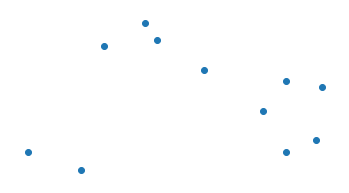

In [3]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(a,b)

plt.axis("off")
ax.set_aspect(1.0)
#plt.savefig("dots.pdf",format="pdf")

## Draw epsilon balls around each point

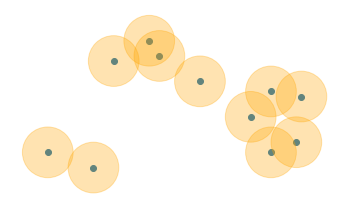

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111)

eps = .1

plt.axis("off")


for i in np.arange(num_points):
    c = plt.Circle((a[i], b[i]), radius=eps/2, color='orange', alpha=.3)
    ax.add_patch(c)

ax.scatter(a,b)

ax.set_aspect(1.0)

#plt.savefig("circles.pdf",format="pdf")

## Draw simplicial complex

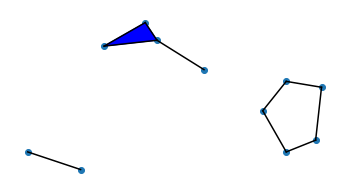

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)

plt.axis("off")

ax.scatter(a,b)


ab = np.hstack((a,b))
D = scipy.spatial.distance.cdist(ab,ab)

for i in np.arange(num_points):
    for j in np.arange(i):
        if D[i,j] < eps:
            ax.plot([a[i],a[j]],[b[i],b[j]],color="black")
            
for i in np.arange(num_points):
    for j in np.arange(i):
        for k in np.arange(j):
            if D[i,j] < eps and D[i,k] < eps and D[j,k] < eps:
                ax.fill([a[i],a[j],a[k]],[b[i],b[j],b[k]],color="blue")

ax.set_aspect(1.0)

#plt.savefig("simplicial_complex.pdf",format="pdf")

## Draw balls and simplicial complexes for any epsilon

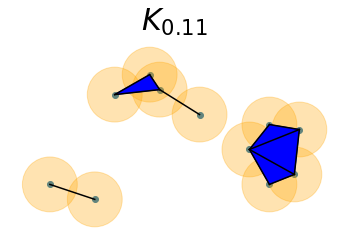

In [6]:
eps = 0.11

fig = plt.figure()
ax = fig.add_subplot(111)

plt.axis("off")

for i in np.arange(num_points):
    c = plt.Circle((a[i], b[i]), radius=eps/2, color='orange', alpha=.3)
    ax.add_patch(c)

ax.scatter(a,b)

ab = np.hstack((a,b))
D = scipy.spatial.distance.cdist(ab,ab)

for i in np.arange(num_points):
    for j in np.arange(i):
        if D[i,j] < eps:
            ax.plot([a[i],a[j]],[b[i],b[j]],color="black")
            
for i in np.arange(num_points):
    for j in np.arange(i):
        for k in np.arange(j):
            if D[i,j] < eps and D[i,k] < eps and D[j,k] < eps:
                ax.fill([a[i],a[j],a[k]],[b[i],b[j],b[k]],color="blue")

ax.set_aspect(1.0)

ax.set_title("$K_{"+str(round(eps,2))+"}$",fontsize=30)

plt.savefig("simplicial_complex_eps_"+str(round(100*eps)).zfill(2)+".pdf",format="pdf")



## Use Ripser to compute the persistent homology

Text(0.5, 1.0, 'Persistence Diagram')

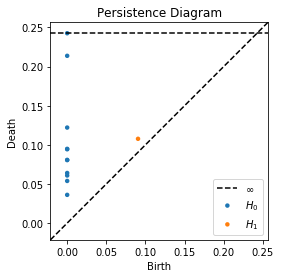

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)

dgms = ripser(np.hstack((a,b)))['dgms']
persim.plot_diagrams(dgms,ax=ax)

ax.set_title("Persistence Diagram")

#plt.savefig("PD.pdf",format="pdf")

## Simulating a swarming model

In [8]:
def dorsogna(t,Z,alpha,beta,cA,cR,lA,lR):
    '''
    Gets derivatives of position and velocity of particles according to the
    D'Orsogna model of soft-core particle interactions.

    Inputs:
        t: (unused) time, for integrator use only
        Z: (1-d ndarray, 4*num_cells long) current step position and velocity

    Parameters:
        alpha: self-propulsion coefficient
        beta: friction coefficient
        cA: attractive amplitude
        cR: repulsive amplitude
        lA: attractive range
        lR: repulsive range

    Output: derivative of position and velocity at current step to be
    integrated to obtain position and velocity at next step
    '''
    meps = np.finfo(np.float64).eps
    #Get ICs from input vector
    num_cells = len(Z)//4
    x = Z[0:num_cells][None,:]
    y = Z[num_cells:2*num_cells][None,:]
    vx = Z[2*num_cells:3*num_cells]
    vy = Z[3*num_cells:]

    #Compute model components
    xdiff = x - x.T
    ydiff = y - y.T 
    D = np.sqrt(xdiff**2+ydiff**2)
    
    with np.errstate(over='raise'):
        v_normSq = vx**2 + vy**2
    

    u_prime = - cA/lA*np.exp(-D/lA) + cR/lR*np.exp(-D/lR)

    dvxdt = (alpha - beta*v_normSq)*vx - np.sum(u_prime*xdiff/(D+meps),axis=1)
    dvydt = (alpha - beta*v_normSq)*vy - np.sum(u_prime*ydiff/(D+meps),axis=1)
    
    
    output = np.hstack((vx,vy,dvxdt,dvydt))

    return output

def ode_rk4(ic_vec,t0,tf,parameters=[1.5,0.5,0.1,1,.1,1]):
    #Simulate position and velocity until last desired frame using RK4/5
    simu = [ic_vec]
    r = ode(dorsogna).set_integrator('dopri5',atol=10**(-3))
    r.set_initial_value(ic_vec,t0).set_f_params(*parameters)
    while r.successful() and r.t < tf:
        print("Simulating frame",int(r.t+1))
        simu.append(r.integrate(r.t+1))
    return simu

In [9]:
#number of agents
num_cells = 100

#intialization
ic_vec = np.random.uniform(-1,1,4*num_cells)

#double ring
alpha,beta,cA,cR,lA,lR = 1.5,0.5,1.0,0.1,1.0,0.1
#single mill
#alpha,beta,cA,cR,lA,lR = 1.5,0.5,1.0,0.5,1.0,0.1
#double mill
#alpha,beta,cA,cR,lA,lR = 1.5,0.5,1.0,0.9,1.0,0.5
#swarm
#alpha,beta,cA,cR,lA,lR = 1.5,0.5,1.0,0.1,1.0,0.5
#Escape
#alpha,beta,cA,cR,lA,lR = 1.5,0.5,1.0,2.0,1.0,0.9


parameters=[alpha,beta,cA,cR,lA,lR]
simulated_cells = ode_rk4(ic_vec,0,100,parameters=parameters)

Simulating frame 1
Simulating frame 2
Simulating frame 3
Simulating frame 4
Simulating frame 5
Simulating frame 6
Simulating frame 7
Simulating frame 8
Simulating frame 9
Simulating frame 10
Simulating frame 11
Simulating frame 12
Simulating frame 13
Simulating frame 14
Simulating frame 15
Simulating frame 16
Simulating frame 17
Simulating frame 18
Simulating frame 19
Simulating frame 20
Simulating frame 21
Simulating frame 22
Simulating frame 23
Simulating frame 24
Simulating frame 25
Simulating frame 26
Simulating frame 27
Simulating frame 28
Simulating frame 29
Simulating frame 30
Simulating frame 31
Simulating frame 32
Simulating frame 33
Simulating frame 34
Simulating frame 35
Simulating frame 36
Simulating frame 37
Simulating frame 38
Simulating frame 39
Simulating frame 40
Simulating frame 41
Simulating frame 42
Simulating frame 43
Simulating frame 44
Simulating frame 45
Simulating frame 46
Simulating frame 47
Simulating frame 48
Simulating frame 49
Simulating frame 50
Simulatin

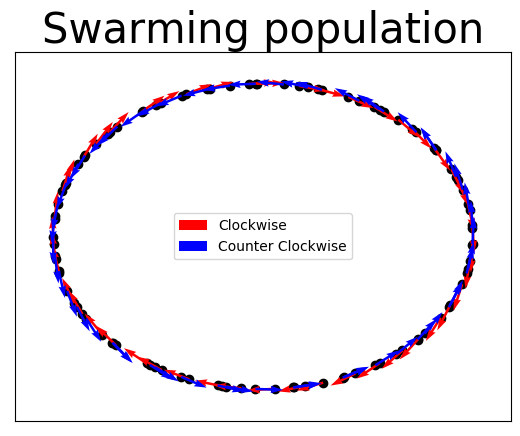

In [10]:
final_time = simulated_cells[-1]

#extract positions and velocities
x = final_time[:num_cells]
y = final_time[num_cells:2*num_cells]
vx = final_time[2*num_cells:3*num_cells]
vy = final_time[3*num_cells:]

#determine clockwise, counter clockwise-moving agents
u = np.vstack([x - np.mean(x),y - np.mean(y)])
v = np.vstack([vx,vy])
w=np.arctan2(u[0,:]*v[1,:]-u[1,:]*v[0,:],u[0,:]*v[0,:]+u[1,:]*v[1,:])

#plot
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(x,y,color="k")
ax.quiver(x[w<0],y[w<0],vx[w<0],vy[w<0],color="r",width=.005,label = "Clockwise")
ax.quiver(x[w>=0],y[w>=0],vx[w>=0],vy[w>=0],color="b",width=.005,label = "Counter Clockwise")

ax.set_xticks([])
ax.set_yticks([])

ax.set_title("Swarming population",fontsize=30)

plt.legend()

plt.savefig("swarm.pdf",format="pdf")

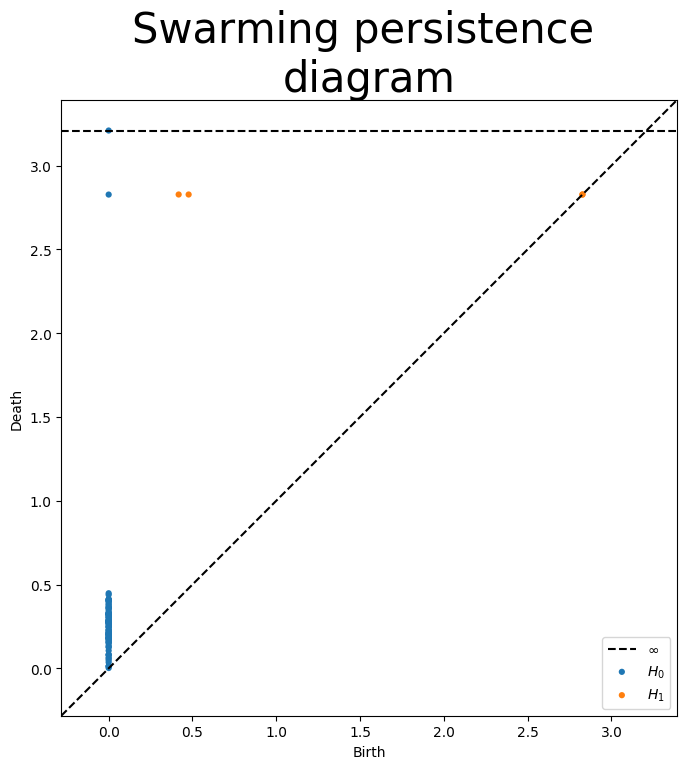

In [11]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

#convert to 2 dimensions
x2, y2, vx2, vy2 = x[:,np.newaxis], y[:,np.newaxis], vx[:,np.newaxis], vy[:,np.newaxis]

#normalize (helps with visualization because position and velocity may be on different scales)
x2_norm = (x2-np.mean(x2))/np.std(x2)
y2_norm = (y2-np.mean(y2))/np.std(y2)
vx2_norm = (vx2-np.mean(vx2))/np.std(vx2)
vy2_norm = (vy2-np.mean(vy2))/np.std(vy2)

#compute and plot persistence diagram
dgms = ripser(np.hstack([x2_norm,y2_norm,vx2_norm,vy2_norm]))['dgms']
persim.plot_diagrams(dgms,ax=ax)

ax.set_title("Swarming persistence \ndiagram",fontsize=30)

plt.savefig("swarm_PD.pdf",format="pdf")